* Code adapted from : [U-net with simple ResNet Blocks v2 (New loss)](https://www.kaggle.com/shaojiaxin/u-net-with-simple-resnet-blocks-v2-new-loss)
  
  
  * Changes:
1.   Using ELU in lovasz loss
  

U-net is convolutional network architecture for fast and precise segmentation of images.  
[5 Minute Teaser Presentation of the U-net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-teaser.mp4)

![U-net Architecture](https://cdn-images-1.medium.com/max/1263/1*aRMefObpm7AMVOZYYiQAMQ.png)

**Red Box** → Representing the left side of U Net 

**Blue Box** → Representing the Right side of U Net

**Green Box** → Final Bottle neck layer.


* The network is composed of Convolution Operation, Max Pooling, ReLU Activation, Concatenation and Up Sampling Layers
* It consists of a contracting path (left side) and an expansive path (right side). 
* The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling.
* At each downsampling step we double the number of feature channels. 
* Every  step  in  the  expansive  path  consists  of  an  upsampling  of  the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature  map  from  the  contracting  path,  and  two  3x3  convolutions,  each  followed by a ReLU. 
* Up-sampling can be done by using [Transpose Convolution Operation](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0).
* The cropping is necessary due to the loss of border pixels in every convolution.
* At the final layer a 1x1 convolution is used to map each 64 component feature vector to the desired number of classes.

In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
t_start = time.time()

/home/vishy/anaconda3/envs/tensorflowenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path = '/home/vishy/Desktop/Kaggle/TGS/Data/'
subpath = '/home/vishy/Desktop/Kaggle/TGS/Submissions/'

In [3]:
version = 15
basic_name = f'Unet_resnet_v{version}'
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

Unet_resnet_v15.model
Unet_resnet_v15.csv


In [4]:
img_size_ori = 101
img_size_target = 101

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [5]:
# Loading of training/testing ids and depths
train_df = pd.read_csv(path+"train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv(path+"depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [6]:
train_df["images"] = [np.array(load_img(path+"train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [7]:
train_df["masks"] = [np.array(load_img(path+"train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [8]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)


In [9]:
SUBSET = len(train_df)
train_df = train_df.head(SUBSET)
len(train_df)

4000

Text(0.5,0,'Coverage class')

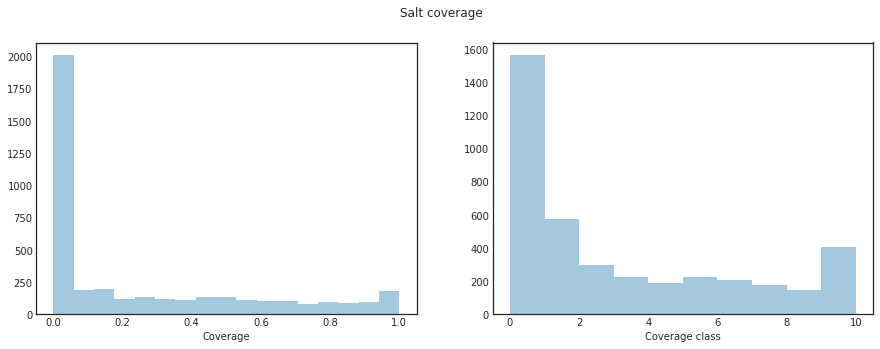

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0.5,1,'Depth distribution')

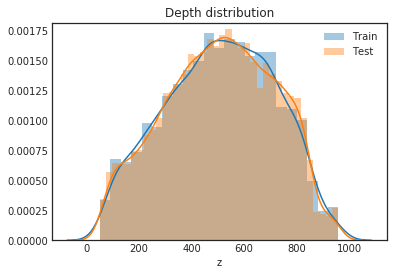

In [11]:
#Plotting the depth distributions¶

sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

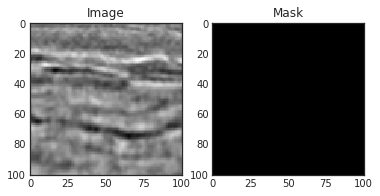

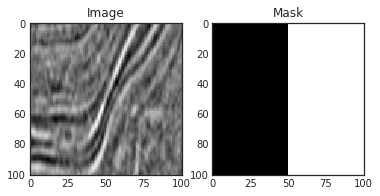

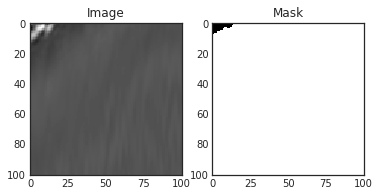

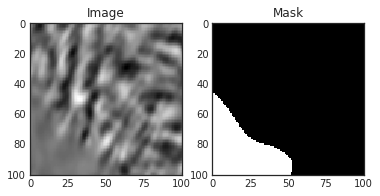

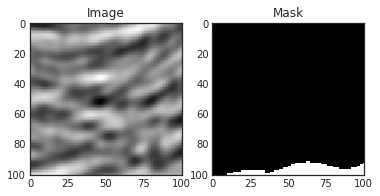

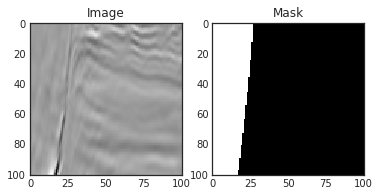

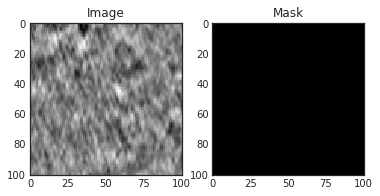

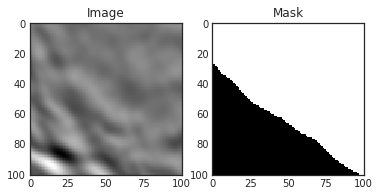

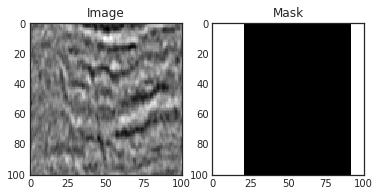

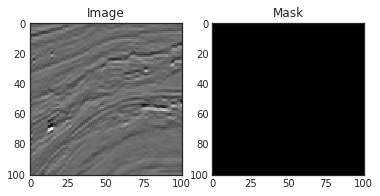

In [12]:
def plot2x2Array(image, mask):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image, cmap="gray")
    axarr[1].imshow(mask, cmap="gray")
    axarr[0].grid(False)
    axarr[1].grid(False)
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')
    
for i, idx in enumerate(train_df.index[:10]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    plot2x2Array(img, mask)

Text(0.5,0.98,'Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

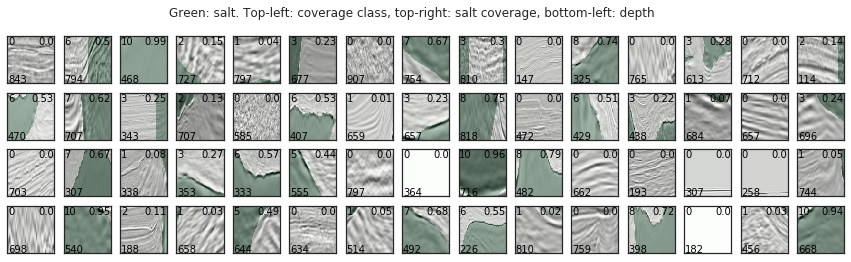

In [13]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [14]:
# Create train/validation split stratified by salt coverage
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

In [16]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x


In [17]:
# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [18]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [19]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        #loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [20]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train.shape)
print(y_valid.shape)

(6400, 101, 101, 1)
(800, 101, 101, 1)


In [21]:
# model
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16,0.5)

model1 = Model(input_layer, output_layer)

c = optimizers.adam(lr = 0.01)
model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])

#model1.summary()

In [24]:
early_stopping = EarlyStopping(monitor='my_iou_metric', mode = 'max',patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)
# old is 100 epochs and 32 batchsize
epochs = 50
batch_size = 16
history = model1.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint,reduce_lr], 
                    verbose=2)

Train on 6400 samples, validate on 800 samples
Epoch 1/50
 - 27s - loss: 0.3404 - my_iou_metric: 0.5129 - val_loss: 0.4122 - val_my_iou_metric: 0.4785

Epoch 00001: my_iou_metric improved from -inf to 0.51291, saving model to Unet_resnet_v15.model
Epoch 2/50
 - 26s - loss: 0.2821 - my_iou_metric: 0.5574 - val_loss: 0.3003 - val_my_iou_metric: 0.5970

Epoch 00002: my_iou_metric improved from 0.51291 to 0.55737, saving model to Unet_resnet_v15.model
Epoch 3/50
 - 27s - loss: 0.2629 - my_iou_metric: 0.5552 - val_loss: 0.5167 - val_my_iou_metric: 0.4885

Epoch 00003: my_iou_metric did not improve from 0.55737
Epoch 4/50
 - 27s - loss: 0.2413 - my_iou_metric: 0.5751 - val_loss: 0.3388 - val_my_iou_metric: 0.4545

Epoch 00004: my_iou_metric improved from 0.55737 to 0.57513, saving model to Unet_resnet_v15.model
Epoch 5/50
 - 27s - loss: 0.2299 - my_iou_metric: 0.5883 - val_loss: 0.2052 - val_my_iou_metric: 0.6312

Epoch 00005: my_iou_metric improved from 0.57513 to 0.58833, saving model to U


Epoch 00044: my_iou_metric improved from 0.75161 to 0.75616, saving model to Unet_resnet_v15.model
Epoch 45/50
 - 27s - loss: 0.1003 - my_iou_metric: 0.7525 - val_loss: 0.1368 - val_my_iou_metric: 0.7449

Epoch 00045: my_iou_metric did not improve from 0.75616
Epoch 46/50
 - 28s - loss: 0.1001 - my_iou_metric: 0.7575 - val_loss: 0.1601 - val_my_iou_metric: 0.7545

Epoch 00046: my_iou_metric improved from 0.75616 to 0.75755, saving model to Unet_resnet_v15.model
Epoch 47/50
 - 27s - loss: 0.1032 - my_iou_metric: 0.7564 - val_loss: 0.1360 - val_my_iou_metric: 0.7518

Epoch 00047: my_iou_metric did not improve from 0.75755
Epoch 48/50
 - 27s - loss: 0.1040 - my_iou_metric: 0.7526 - val_loss: 0.1642 - val_my_iou_metric: 0.7479

Epoch 00048: my_iou_metric did not improve from 0.75755
Epoch 49/50
 - 28s - loss: 0.1012 - my_iou_metric: 0.7507 - val_loss: 0.1211 - val_my_iou_metric: 0.7588

Epoch 00049: my_iou_metric did not improve from 0.75755
Epoch 50/50
 - 27s - loss: 0.1032 - my_iou_metr

In [25]:
model1 = load_model(save_model_name,custom_objects={'my_iou_metric': my_iou_metric})
# remove layter activation layer and use losvasz loss
input_x = model1.layers[0].input

output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
c = optimizers.adam(lr = 0.01)

# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

#model.summary()

In [26]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)
epochs = 200
batch_size = 64

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint,reduce_lr,early_stopping], 
                    verbose=2)

Train on 6400 samples, validate on 800 samples
Epoch 1/200
 - 82s - loss: -9.8857e-02 - my_iou_metric_2: 0.7937 - val_loss: -6.5795e-03 - val_my_iou_metric_2: 0.7917

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.79175, saving model to Unet_resnet_v15.model
Epoch 2/200
 - 73s - loss: -1.6287e-01 - my_iou_metric_2: 0.8038 - val_loss: 0.0417 - val_my_iou_metric_2: 0.7766

Epoch 00002: val_my_iou_metric_2 did not improve from 0.79175
Epoch 3/200
 - 73s - loss: -1.9468e-01 - my_iou_metric_2: 0.8100 - val_loss: -4.0905e-02 - val_my_iou_metric_2: 0.7865

Epoch 00003: val_my_iou_metric_2 did not improve from 0.79175
Epoch 4/200
 - 73s - loss: -2.1975e-01 - my_iou_metric_2: 0.8140 - val_loss: -1.1006e-02 - val_my_iou_metric_2: 0.7753

Epoch 00004: val_my_iou_metric_2 did not improve from 0.79175
Epoch 5/200
 - 73s - loss: -2.3343e-01 - my_iou_metric_2: 0.8153 - val_loss: -7.1750e-02 - val_my_iou_metric_2: 0.7930

Epoch 00005: val_my_iou_metric_2 improved from 0.79175 to 0.79300, sav


Epoch 00042: val_my_iou_metric_2 did not improve from 0.80988

Epoch 00042: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
Epoch 43/200
 - 73s - loss: -4.4273e-01 - my_iou_metric_2: 0.8535 - val_loss: -9.1022e-02 - val_my_iou_metric_2: 0.8066

Epoch 00043: val_my_iou_metric_2 did not improve from 0.80988
Epoch 44/200
 - 73s - loss: -4.5710e-01 - my_iou_metric_2: 0.8578 - val_loss: -8.1279e-02 - val_my_iou_metric_2: 0.8072

Epoch 00044: val_my_iou_metric_2 did not improve from 0.80988
Epoch 45/200
 - 73s - loss: -4.5293e-01 - my_iou_metric_2: 0.8564 - val_loss: -8.1250e-02 - val_my_iou_metric_2: 0.8049

Epoch 00045: val_my_iou_metric_2 did not improve from 0.80988
Epoch 46/200
 - 73s - loss: -4.5831e-01 - my_iou_metric_2: 0.8565 - val_loss: -7.1460e-02 - val_my_iou_metric_2: 0.8051

Epoch 00046: val_my_iou_metric_2 did not improve from 0.80988
Epoch 47/200
 - 73s - loss: -4.5861e-01 - my_iou_metric_2: 0.8579 - val_loss: -7.5159e-02 - val_my_iou_metric_2: 0.8024

Epo

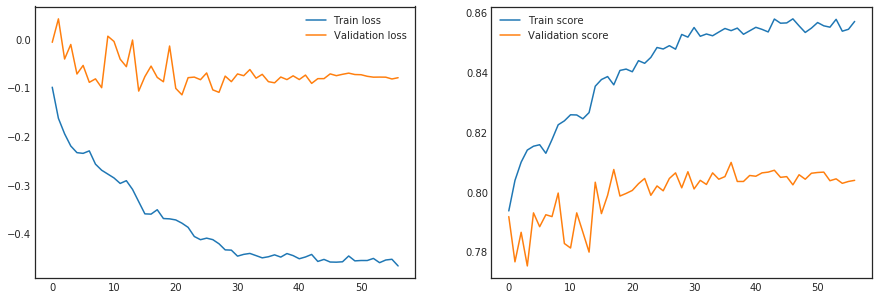

In [27]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

In [28]:
model = load_model(save_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

In [29]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [30]:
preds_valid = predict_result(model,x_valid,img_size_target)

In [31]:
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))

    intersection = temp1[0]

    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
      
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)



In [32]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)


[0.80975  0.81     0.811    0.81175  0.8125   0.812625 0.812125 0.812
 0.8125   0.813375 0.814625 0.8145   0.815875 0.81575  0.81475  0.814125
 0.813625 0.813625 0.812875 0.814    0.814125 0.81375  0.814375 0.813625
 0.81375  0.813125 0.812125 0.810875 0.8115   0.81325  0.812375]


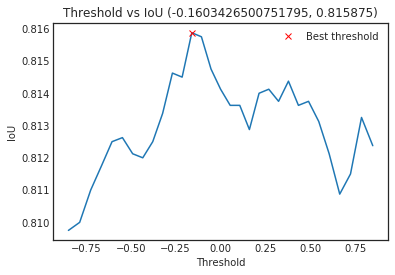

In [33]:
# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [34]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [35]:
x_test = np.array([(np.array(load_img(path+"test/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)



In [36]:
preds_test = predict_result(model,x_test,img_size_target)

In [37]:
t1 = time.time()
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")


Usedtime = 3.149320602416992 s


In [38]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(subpath+submission_file)

# Applying CRF

In [33]:
import numpy as np
import pydensecrf.densecrf as dcrf
from skimage.io import imread, imsave
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
%matplotlib inline

In [34]:
def rle_decode(rle_mask):
    '''
    rle_mask: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(101*101, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(101,101)

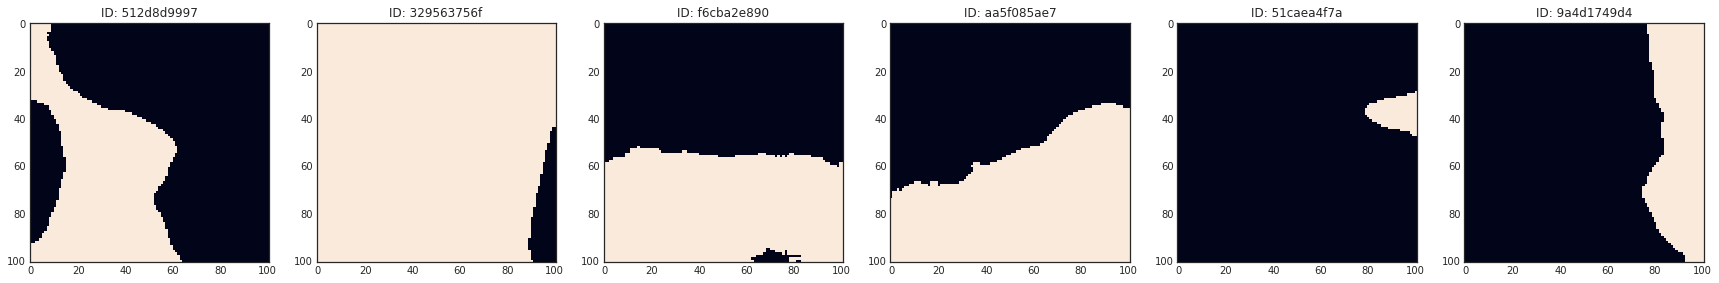

In [35]:
"""
reading and decoding the submission 

"""
df = pd.read_csv(subpath+'Unet_resnet_v14.csv')
i = 0
j = 0
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
# Visualizing the predicted outputs
while True:
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])
        plt.subplot(1,6,j+1)
        plt.imshow(decoded_mask)
        plt.title('ID: '+df.loc[i,'id'])
        j = j + 1
        if j>5:
            break
    i = i + 1

In [36]:
"""
Function which returns the labelled image after applying CRF

"""
#Original_image = Image which has to labelled
#Mask image = Which has been labelled by some technique..
def crf(original_image, mask_img):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(mask_img.shape)<3):
        mask_img = gray2rgb(mask_img)

#     #Converting the annotations RGB color to single 32 bit integer
    annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    
#     # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 10 steps 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [37]:
test_path = '/home/vishy/Desktop/Kaggle/TGS/Data/test/'

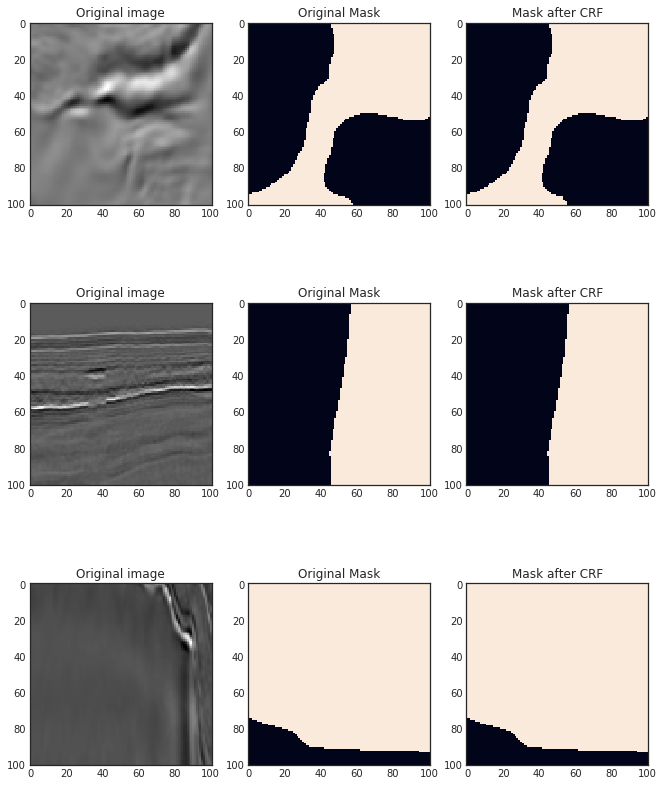

In [38]:
"""
visualizing the effect of applying CRF

"""
nImgs = 3
i = np.random.randint(1000)
j = 1
plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0.2,hspace=0.1)  #adjust this to change vertical and horiz. spacings..
while True:
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])        
        orig_img = imread(test_path+df.loc[i,'id']+'.png')
        #Applying CRF on FCN-16 annotated image
        crf_output = crf(orig_img,decoded_mask)
        plt.subplot(nImgs,4,4*j-3)
        plt.imshow(orig_img)
        plt.title('Original image')
        plt.subplot(nImgs,4,4*j-2)
        plt.imshow(decoded_mask) 
        plt.title('Original Mask')
        plt.subplot(nImgs,4,4*j-1)
        plt.imshow(crf_output) 
        plt.title('Mask after CRF')
        if j == nImgs:
            break
        else:
            j = j + 1
    i = i + 1

In [39]:
"""
used for converting the decoded image to rle mask

"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [40]:
"""
Applying CRF on the predicted mask 

"""
for i in tqdm(range(df.shape[0])):
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])        
        orig_img = imread(test_path+df.loc[i,'id']+'.png')        
        crf_output = crf(orig_img,decoded_mask)
        df.loc[i,'rle_mask'] = rle_encode(crf_output)

100%|██████████| 18000/18000 [02:04<00:00, 144.76it/s]


In [41]:
df.to_csv(subpath+'submission15_crf.csv',index=False)

In [36]:
t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")

Kernel run time = 1.6768558693594402 hours
